# Imaging and structure analysis of ferroelectric domains, domain walls, and vortices by scanning electron diffraction

Ursula Ludacka<sup>1</sup>, Jiali He<sup>1</sup>, Shuyu Qin<sup>3,4</sup>, Manuel Zahn<sup>1,5</sup>, Emil Frang Christiansen<sup>2</sup>, Kasper A. Hunnestad<sup>1</sup>, Zewu Yan<sup>6,7</sup>, Edith Bourret<sup>7</sup>, István Kézsmárki<sup>5</sup>, Antonius T. J. van Helvoort<sup>2</sup>, Joshua Agar<sup>3,4</sup>, Dennis Meier<sup>1</sup>

Email: dennis.meier@ntnu.no, jca92@drexel.edu

<sup>1</sup> Department of Materials Science and Engineering, NTNU Norwegian University of Science and Technology, Trondheim, Norway \
<sup>2</sup> Department of Physics, NTNU Norwegian University of Science and Technology, Trondheim, Norway\
<sup>3</sup> Department of Materials Science and Engineering, Lehigh University, Bethlehem, USA\
<sup>4</sup> Department of Mechanical Engineering and Mechanics, Drexel University, Philadelphia, USA\
<sup>5</sup> Experimental Physics V, University of Augsburg, Augsburg, Germany\
<sup>6</sup> Department of Physics, ETH Zurich, Zürich, Switzerland.\
<sup>7</sup> Materials Sciences Division, Lawrence Berkeley National Laboratory, Berkeley, USA.


## Abstract

Direct electron detectors in scanning transmission electron microscopy give unprecedented possibilities for structure analysis at the nanoscale. In electronic and quantum materials, this new capability gives access to, for example, emergent chiral structures and symmetry-breaking distortions that underpin functional properties. Quantifying nanoscale structural features with statistical significance, however, is complicated by the subtleties of dynamic diffraction and coexisting contrast mechanisms, which often results in low signal-to-noise and the superposition of multiple signals that are challenging to deconvolute. Here we apply scanning electron diffraction to explore local polar distortions in the uniaxial ferroelectric Er(Mn,Ti)O3. Using a custom-designed convolutional autoencoder with bespoke regularization, we demonstrate that subtle variations in the scattering signatures of ferroelectric domains, domain walls, and vortex textures can readily be disentangled with statistical significance and separated from extrinsic contributions due to, e.g., variations in specimen thickness or bending. The work demonstrates a pathway to quantitatively measure symmetry-breaking distortions across large areas, mapping structural changes at interfaces and topological structures with nanoscale spatial resolution.


$$L = \frac{\lambda}{2N} \sum\limits_{i=1}^{N} \left[\left(\sum\limits_{j=1, j\neq i}^{N} \frac{latent_i \cdot latent_j}{\left\lVert latent_i \right\rVert \left\lVert latent_j \right\rVert}\right] - 1\right)$$


In [1]:
%load_ext autoreload
%autoreload 2

In [9]:
import sys

sys.path.append("../../")
sys.path.append("/home/ferroelectric/m3_learning/m3_learning/src")


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import hyperspy.api as hs
import torch

from m3_learning.nn.random import random_seed
from m3_learning.nn.STEM_AE.Viz import Viz
from m3_learning.nn.STEM_AE.STEM_AE import ConvAutoencoder
from m3_learning.viz.style import set_style
from m3_learning.viz.printing import printer
from m3_learning.viz.layout import layout_fig, imagemap, labelfigs, scalebar
from m3_learning.viz.Movies import make_movie
printing = printer(basepath='./figures/')


set_style("printing")
random_seed(seed=42)

%matplotlib inline


printing set for seaborn
Pytorch seed was set to 42
Numpy seed was set to 42
tensorflow seed was set to 42


TODO: add download


In [4]:
class STEM_Dataset:
    def __init__(self, data_path):
        s = hs.load(data_path,
            reader="hspy",
            lazy=False,
        )
        self.data = s.data
        self.log_data = s

    @property
    def log_data(self):
        return self._log_data

    @log_data.setter
    def log_data(self, log_data):
        self._log_data = np.log(log_data.data + 1)

In [5]:
# loads the dataset
# this object will also compute the log of the dataset
# this is available as self.log_data
domain = STEM_Dataset(data_path="/home/ferroelectric/data/256p_3w_step1k4_a5_cl12_50ms_nmf_4.hspy")

/home/ferroelectric/anaconda3/envs/STEM/lib/python3.9/site-packages/hyperspy/misc/utils.py:471: VisibleDeprecationWarning: Use of the `binned` attribute in metadata is going to be deprecated in v2.0. Set the `axis.is_binned` attribute instead. 
  warnings.warn(
/home/ferroelectric/anaconda3/envs/STEM/lib/python3.9/site-packages/hyperspy/io.py:572: VisibleDeprecationWarning: Loading old file version. The binned attribute has been moved from metadata.Signal to axis.is_binned. Setting this attribute for all signal axes instead.
  warnings.warn('Loading old file version. The binned attribute '


In [6]:
# instantiates the visualization class
viz = Viz(printer = printing, labelfigs_=True)

./figures/STEM_raw_and_virtual_domain.png
./figures/STEM_raw_and_virtual_domain.svg


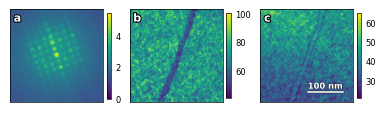

In [7]:
bright_field_ = (117,135, 119, 135)
dark_field_ = (102,117, 114,130)
printer_ = printer(basepath="./figures/")
filename = "STEM_raw_and_virtual_domain"
scalebar_ = {'width': 250, 'scale length': 100, 'units': 'nm'}

viz.STEM_raw_and_virtual(domain, bright_field_=bright_field_, dark_field_=dark_field_, scalebar_=scalebar_, filename=filename)

In [8]:
encoder_step_size = [256, 256]
pooling_list = [4, 4, 2]
decoder_step_size = [8, 8]
upsampling_list = [2, 4, 4]
embedding_size = 32
conv_size = 128

# set device to load model
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda:1'

model = ConvAutoencoder(encoder_step_size=encoder_step_size,
                        pooling_list=pooling_list,
                        decoder_step_size=decoder_step_size,
                        upsampling_list=upsampling_list,
                        embedding_size=embedding_size,
                        conv_size=conv_size,
                        device=device,
                        learning_rate=3e-5)

In [9]:
# set retrain parameter
train = False

if train:
    model.Train(domain.log_data,
          coef_1=1e-5,
          epochs=225,
          with_scheduler=False,
          folder_path="Domain_Weights",
          batch_size=256)
else:
    model.load_weights("/home/ferroelectric/data/11.23_log_epoch_0376_coef_1e-05_trainloss_0.1362.pkl")

In [10]:
embedding = model.get_embedding(domain.log_data)

100%|██████████| 2048/2048 [04:07<00:00,  8.28it/s]


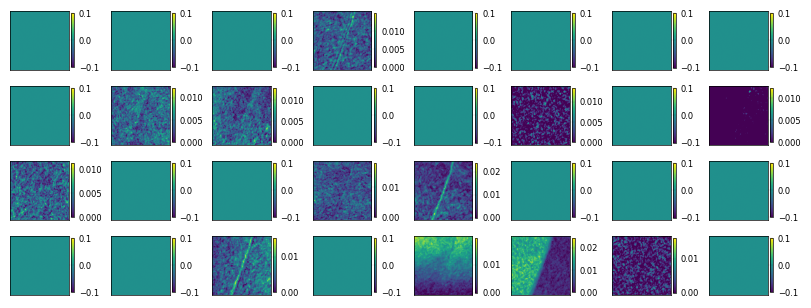

In [11]:
fig, axs = layout_fig(32,8, figsize=(8,3))

for i in range(32):
    imagemap(axs[i], embedding[:,i].reshape(256,256), divider_=False)


In [12]:
viz.model = model
viz.channels = channels = [20,29]

In [13]:
# fig, ax = layout_fig(2,1)
# imagemap(ax[0], embedding[:, 20].reshape(
#                     256, 256), clim=[0,0.018])


In [14]:
# type(axes[0])
# type(ax[0])

In [15]:
# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# # Inset axis with default outer axes bounds
# axes[0].inset_axes([0.4, 0.4, 0.2, 0.2])

# # Inset axis with different outer axes bounds
# axes[1].inset_axes([0.4, 0.4, 0.2, 0.2])
# axes[1].set_xlim(-1, 5)
# axes[1].set_ylim(2.6, 10.3)

# plt.tight_layout()

In [16]:
# fig, ax = layout_fig(2,2, figsize=(2.5, 1.25))

# pos = ax[0].get_position()

# x_size, y_size =  pos.x1 - pos.x0, pos.y1 - pos.y0

# x_size = x_size/2
# y_size = y_size/2



# as_ = fig.add_axes([pos.x1-x_size, pos.y1-y_size, x_size, y_size])  
# as_.set_xticklabels("")
# as_.set_yticklabels("")

In [ ]:
model.embedding = embedding

ranges=[[0,0.018],[0,0.022]]
folder_name = 'Generator_of_Figure_4_a_d'

viz.generator_images(ranges = ranges, folder_name = folder_name, figsize=(3, 1.25), cbar_number_format = "%d")

In [12]:
folder = "/home/ferroelectric/m3_learning/m3_learning/papers/2023_Imaging_ferroelectric_domains_by_scanning_electron_diffraction/figures/generator_images_Generator_of_Figure_4_a_d/"

make_movie('movie',
           folder,
           folder,
          'png',
          3)

['/home/ferroelectric/m3_learning/m3_learning/papers/2023_Imaging_ferroelectric_domains_by_scanning_electron_diffraction/figures/generator_images_Generator_of_Figure_4_a_d/0000_maps.png', '/home/ferroelectric/m3_learning/m3_learning/papers/2023_Imaging_ferroelectric_domains_by_scanning_electron_diffraction/figures/generator_images_Generator_of_Figure_4_a_d/0001_maps.png', '/home/ferroelectric/m3_learning/m3_learning/papers/2023_Imaging_ferroelectric_domains_by_scanning_electron_diffraction/figures/generator_images_Generator_of_Figure_4_a_d/0002_maps.png', '/home/ferroelectric/m3_learning/m3_learning/papers/2023_Imaging_ferroelectric_domains_by_scanning_electron_diffraction/figures/generator_images_Generator_of_Figure_4_a_d/0003_maps.png', '/home/ferroelectric/m3_learning/m3_learning/papers/2023_Imaging_ferroelectric_domains_by_scanning_electron_diffraction/figures/generator_images_Generator_of_Figure_4_a_d/0004_maps.png', '/home/ferroelectric/m3_learning/m3_learning/papers/2023_Imaging

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [33]:
import cv2
import glob 

input_folder = "/home/ferroelectric/m3_learning/m3_learning/papers/2023_Imaging_ferroelectric_domains_by_scanning_electron_diffraction/figures/generator_images_Generator_of_Figure_4_a_d"
file_format = 'png'
reverse = False
movie_name = "movie"
output_folder = input_folder
fps = 3

# searches the folder and finds the files
file_list = glob.glob(input_folder + '/*.' + file_format)

# Sorts the files by number makes 2 lists to go forward and back
list.sort(file_list)
file_list_rev = glob.glob(input_folder + '/*.' + file_format)
list.sort(file_list_rev, reverse=True)

# combines the file list if including the reverse
if reverse:
    new_list = file_list + file_list_rev
else:
    new_list = file_list

print(new_list)

# Create the video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
size = cv2.imread(new_list[0]).shape
video_writer = cv2.VideoWriter(
    f"{output_folder}/{movie_name}.mp4", fourcc, fps, (size[1], size[0]))

print(f"{output_folder}{movie_name}")
# Add frames to the video
for image in new_list:
    frame = cv2.imread(image)
    video_writer.write(frame)

video_writer.release()

# Release the resources
cv2.destroyAllWindows()

['/home/ferroelectric/m3_learning/m3_learning/papers/2023_Imaging_ferroelectric_domains_by_scanning_electron_diffraction/figures/generator_images_Generator_of_Figure_4_a_d/0000_maps.png', '/home/ferroelectric/m3_learning/m3_learning/papers/2023_Imaging_ferroelectric_domains_by_scanning_electron_diffraction/figures/generator_images_Generator_of_Figure_4_a_d/0001_maps.png', '/home/ferroelectric/m3_learning/m3_learning/papers/2023_Imaging_ferroelectric_domains_by_scanning_electron_diffraction/figures/generator_images_Generator_of_Figure_4_a_d/0002_maps.png', '/home/ferroelectric/m3_learning/m3_learning/papers/2023_Imaging_ferroelectric_domains_by_scanning_electron_diffraction/figures/generator_images_Generator_of_Figure_4_a_d/0003_maps.png', '/home/ferroelectric/m3_learning/m3_learning/papers/2023_Imaging_ferroelectric_domains_by_scanning_electron_diffraction/figures/generator_images_Generator_of_Figure_4_a_d/0004_maps.png', '/home/ferroelectric/m3_learning/m3_learning/papers/2023_Imaging

In [28]:
cv2.imread(new_list[0]).shape[0:2]

(861, 1875)